This notebook calculates a time series of modelled CIL area from 1993-2020.
 * Models used:
     * GLORYS12v1 Reanalysis - 1993-2019
     * PSY4 - 2020
In addition, a climatololgical CIL are is calcualted using an average of 1993-2018 July conditions from GLORYS12v1


In [1]:
import glob
import os
import datetime

import geopy.distance
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr

%matplotlib inline

# Define settings and paths

## Global constants

In [2]:
# Some global constants
transect_labels = {'SealIsland': 'SI'}
default_transect_days = {'SealIsland': '07-15'}
default_transect_months = {'SealIsland': [7,8]}
sub_domains = {'SealIsland': [-56,53,-52,56]}
# Year for switching from GLORYS to PSY4
switch_year = 2020

## Set the transect and load positions

In [3]:
# Settings for this transect
transect='SealIsland'
stations = pd.read_table('../../data/csv/transects/{}/{}.txt'.format(transect, transect.lower()), 
                         delimiter=' ')

## Model data paths

In [4]:
hank_dir='/home/soontiensn/remote2/hank/'
csv_outputs = '../../data/csv/transects/{}'.format(transect)
glorys=os.path.join(
    hank_dir,
    'cmems/GLOBAL_REANALYSIS_PHY_001_030/global-reanalysis-phy-001-030-daily/')
psy4=os.path.join(
    hank_dir,
    'nrt.cmems-du.eu/GLOBAL_ANALYSIS_FORECAST_PHY_001_024/global-analysis-forecast-phy-001-024/')

## Observed data paths

In [5]:
azmp = '/home/soontiensn/data/AZMP/NetCDF/'

# Functions to support data look up

In [6]:
def identify_transect_date(year, transect):
    """Identify the day the observed transect as taken in a given year.
    If no data for a given year, use"""
    file=os.path.join(azmp,'{}.nc'.format(year))
    if os.path.exists(file):
        d = xr.open_dataset(file)
        comments = d.comments.values
        label = transect_labels[transect]
        # Find inds of all comments with label
        inds = []
        for i in range(len(comments)):
            c = comments[i]
            if c.startswith(label) and '{}-'.format(label) in c:
                inds.append(i)
        times = d.time.values[inds]
        times.sort()
        # Arbitrarily choose first date for model lookup
        times = [t for t in times if pd.DatetimeIndex([t,]).month in default_transect_months[transect]]
    else:
        times = [np.datetime64('{}-{}'.format(year,default_transect_days[transect]))]
    return np.unique([datetime.datetime.strptime(np.datetime_as_string(t, unit='D'), '%Y-%m-%d') for t in times])

In [7]:
def load_psy4_data(psy4_path, date, transect, csv_outputs, variable='Temperature [degrees_C]'):
    #Look up CSV file first
    csv = os.path.join(csv_outputs,'global-analysis-forecast-phy-001-024', date.strftime('%Y'),
                       '{}_{}.csv'.format(transect, date.strftime('%Y_mercatorpsy4v3r1_gl12_mean_%Y%m%d'))
                      )
    if not os.path.exists(csv):
        # Load netcdf and create csv to load later
        s = glob.glob(os.path.join(psy4_path,date.strftime('%Y/%m/*_%Y%m%d_*.nc')))[0]
        print("Loading netcdf: {}".format(s))
        d = xr.open_dataset(s)
        # subset
        sd=sub_domains[transect]
        d = d.sel(longitude=slice(sd[0],sd[2]), latitude=slice(sd[1], sd[3]))
        df = interp_to_stations(d, stations)
        df.to_csv(csv,  index=False, na_rep='nan')
    # Load csv
    distance, depths, var = load_csv(csv, stations)
    return distance, depths, var

In [8]:
def load_glorys_data(glorys_path, date, transect, csv_outputs, variable='Temperature [degrees_C]'):
    #Look up CSV file first
    csv = os.path.join(csv_outputs, 'global-reanalysis-phy-001-030-daily', date.strftime('%Y'),
                       '{}_{}.csv'.format(transect, date.strftime('%Y_mercatorglorys12v1_gl12_mean_%Y%m%d'))
                      )
    if not os.path.exists(csv):
        # Load netcdf and create csv to load later
        s = glob.glob(os.path.join(glorys_path, date.strftime('%Y/%m/*_%Y%m%d_*.nc')))[0]
        print("Loading netcdf: {}".format(s))
        d = xr.open_dataset(s)
        # subset
        sd=sub_domains[transect]
        d = d.sel(longitude=slice(sd[0],sd[2]), latitude=slice(sd[1], sd[3]))
        df = interp_to_stations(d, stations)
        df.to_csv(csv,  index=False, na_rep='nan')
    # Load csv
    distance, depths, var = load_csv(csv, stations)
    return distance, depths, var

In [9]:
def interp_to_stations(d, stations, variable='thetao'):
    drop=[]
    for v in d.variables:
        if v not in [variable, 'longitude', 'time', 'latitude', 'depth']:
            drop.append(v)
    print("Interpolating data to stations")
    dnew = pd.DataFrame()
    numrows=stations.shape[0]
    numdepths=d.depth.values.shape[0]
    for i in range(stations.shape[0]):
        print('Station {} of {}'.format(i, stations.shape[0]))
        lat=stations.iloc[i]['LAT']
        lon=stations.iloc[i]['LON']
        sid=stations.iloc[i]['STATION']
        dstation = d.interp(latitude=lat, longitude=lon)
        dstation = dstation.drop(drop)
        df=dstation.to_dataframe()
        df['station'] = sid
        df = df.reset_index()
        dnew = pd.concat([dnew,df])
    # Rename columns
    rename={var: '{} [{}]'.format(d[var].attrs['long_name'], d[var].attrs['units'])
        for var in dnew.columns if var not in ['station', 'time']}
    rename['station'] = 'STATION'
    rename['time'] = 'TIME'
    rename['longitude'] = 'LON'
    rename['latitude'] = 'LAT'
    dnew = dnew.rename(columns=rename)
    dnew = dnew.reset_index(drop=True)
    return dnew

In [10]:
def load_csv(fname, stations, variable='Temperature [degrees_C]'):
    print("Loading csv: {}".format(fname))
    d = pd.read_csv(fname)
    numstations=stations.shape[0]
    # distance along transect in km
    distance = [geopy.distance.distance((stations.iloc[0]['LAT'], stations.iloc[0]['LON']),
                                        (stations.iloc[i]['LAT'], stations.iloc[i]['LON'])).km for i in range(numstations)]
    # Create arrays
    var = d[variable].values
    depths = d['Depth [m]'].values
    size=len(var)
    # Reshape data
    numdepths = int(size/numstations)
    var = var.reshape((numstations, numdepths ))
    var = np.ma.masked_invalid(var)
    depths = depths.reshape((numstations, numdepths))
    _, distance = np.meshgrid(depths[0, :], distance)
    return distance, depths, var

# Functions to support calculations

In [11]:
def regrid(xo, yo, tempo, nx=100, ny=100, depthmax=700):
    xnew = np.linspace(xo[0,0],xo[-1,0], num=nx )
    ynew = np.linspace(yo[0,0],depthmax, num=ny )
    yy,xx = np.meshgrid(ynew, xnew)
    tempnew = interp.griddata((xo.flatten(),yo.flatten()),temp.flatten(), (xx,yy))
    tempnew = np.ma.masked_invalid(tempnew)
    return xx, yy, tempnew

In [12]:
def plot_transect(x,y,t,ax, contour=True):
    if contour:
        mesh=ax.contourf(x,y,t,cmap='plasma',levels=np.linspace(-2,10))
    else:
        below_zero = np.ma.masked_greater(t,0)
        mesh=ax.pcolormesh(x,y,below_zero,cmap='plasma',vmin=-2,vmax=10)
    contour = ax.contour(x, y, t, [0,], colors='k')
    mask=t.mask
    cmask = ax.contour(distance, depths, mask, [1,], colors='k')
    cbar = plt.colorbar(mesh,ax=ax)
    cbar.set_label('Temperature [deg C]')
    ax.set_ylim([500,0])
    ax.set_ylabel('Depth [m]')
    ax.set_xlabel('Distance [km]')
    ax.grid()

In [13]:
def calculate_area(x,y,temp):
    below_zero = np.ma.masked_greater(temp, 0)
    diffs_x = np.diff(x, axis=0)
    diffs_y = np.diff(y, axis=1)
    area = np.nansum(diffs_x[:, :-1]*diffs_y[:-1, :]/1000*(1-below_zero.mask[:-1,:-1]))
    return area

# Loop through years

Processing year: 1993
Loading csv: ../../data/csv/transects/SealIsland/global-reanalysis-phy-001-030-daily/1993/SealIsland_1993_mercatorglorys12v1_gl12_mean_19930715.csv


/home/soontiensn/miniconda/envs/analysis/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: No contour levels were found within the data range.
  if __name__ == '__main__':


Processing year: 1994
Loading csv: ../../data/csv/transects/SealIsland/global-reanalysis-phy-001-030-daily/1994/SealIsland_1994_mercatorglorys12v1_gl12_mean_19940715.csv
Processing year: 1995
Loading csv: ../../data/csv/transects/SealIsland/global-reanalysis-phy-001-030-daily/1995/SealIsland_1995_mercatorglorys12v1_gl12_mean_19950715.csv
Processing year: 1996
Loading csv: ../../data/csv/transects/SealIsland/global-reanalysis-phy-001-030-daily/1996/SealIsland_1996_mercatorglorys12v1_gl12_mean_19960715.csv
Processing year: 1997
Loading csv: ../../data/csv/transects/SealIsland/global-reanalysis-phy-001-030-daily/1997/SealIsland_1997_mercatorglorys12v1_gl12_mean_19970715.csv
Processing year: 1998
Loading csv: ../../data/csv/transects/SealIsland/global-reanalysis-phy-001-030-daily/1998/SealIsland_1998_mercatorglorys12v1_gl12_mean_19980715.csv
Processing year: 1999
Loading csv: ../../data/csv/transects/SealIsland/global-reanalysis-phy-001-030-daily/1999/SealIsland_1999_mercatorglorys12v1_gl1

/home/soontiensn/miniconda/envs/analysis/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: No contour levels were found within the data range.
  if __name__ == '__main__':


Processing year: 2000
Loading csv: ../../data/csv/transects/SealIsland/global-reanalysis-phy-001-030-daily/2000/SealIsland_2000_mercatorglorys12v1_gl12_mean_20000723.csv


/home/soontiensn/miniconda/envs/analysis/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: No contour levels were found within the data range.
  if __name__ == '__main__':


Loading csv: ../../data/csv/transects/SealIsland/global-reanalysis-phy-001-030-daily/2000/SealIsland_2000_mercatorglorys12v1_gl12_mean_20000724.csv
Loading csv: ../../data/csv/transects/SealIsland/global-reanalysis-phy-001-030-daily/2000/SealIsland_2000_mercatorglorys12v1_gl12_mean_20000725.csv
Processing year: 2001
Loading csv: ../../data/csv/transects/SealIsland/global-reanalysis-phy-001-030-daily/2001/SealIsland_2001_mercatorglorys12v1_gl12_mean_20010721.csv


/home/soontiensn/miniconda/envs/analysis/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: No contour levels were found within the data range.
  if __name__ == '__main__':


Loading csv: ../../data/csv/transects/SealIsland/global-reanalysis-phy-001-030-daily/2001/SealIsland_2001_mercatorglorys12v1_gl12_mean_20010722.csv
Processing year: 2002
Loading csv: ../../data/csv/transects/SealIsland/global-reanalysis-phy-001-030-daily/2002/SealIsland_2002_mercatorglorys12v1_gl12_mean_20020722.csv
Loading csv: ../../data/csv/transects/SealIsland/global-reanalysis-phy-001-030-daily/2002/SealIsland_2002_mercatorglorys12v1_gl12_mean_20020723.csv


/home/soontiensn/miniconda/envs/analysis/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: No contour levels were found within the data range.
  if __name__ == '__main__':


Processing year: 2003
Loading csv: ../../data/csv/transects/SealIsland/global-reanalysis-phy-001-030-daily/2003/SealIsland_2003_mercatorglorys12v1_gl12_mean_20030730.csv


/home/soontiensn/miniconda/envs/analysis/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: No contour levels were found within the data range.
  if __name__ == '__main__':


Loading csv: ../../data/csv/transects/SealIsland/global-reanalysis-phy-001-030-daily/2003/SealIsland_2003_mercatorglorys12v1_gl12_mean_20030731.csv
Processing year: 2004
Loading csv: ../../data/csv/transects/SealIsland/global-reanalysis-phy-001-030-daily/2004/SealIsland_2004_mercatorglorys12v1_gl12_mean_20040730.csv
Loading csv: ../../data/csv/transects/SealIsland/global-reanalysis-phy-001-030-daily/2004/SealIsland_2004_mercatorglorys12v1_gl12_mean_20040731.csv


/home/soontiensn/miniconda/envs/analysis/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: No contour levels were found within the data range.
  if __name__ == '__main__':


Processing year: 2005
Loading csv: ../../data/csv/transects/SealIsland/global-reanalysis-phy-001-030-daily/2005/SealIsland_2005_mercatorglorys12v1_gl12_mean_20050727.csv


/home/soontiensn/miniconda/envs/analysis/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: No contour levels were found within the data range.
  if __name__ == '__main__':
/home/soontiensn/miniconda/envs/analysis/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Loading csv: ../../data/csv/transects/SealIsland/global-reanalysis-phy-001-030-daily/2005/SealIsland_2005_mercatorglorys12v1_gl12_mean_20050728.csv
Processing year: 2006
Loading csv: ../../data/csv/transects/SealIsland/global-reanalysis-phy-001-030-daily/2006/SealIsland_2006_mercatorglorys12v1_gl12_mean_20060804.csv
Loading csv: ../../data/csv/transects/SealIsland/global-reanalysis-phy-001-030-daily/2006/SealIsland_2006_mercatorglorys12v1_gl12_mean_20060805.csv


/home/soontiensn/miniconda/envs/analysis/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/soontiensn/miniconda/envs/analysis/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: No contour levels were found within the data range.
  if __name__ == '__main__':


Loading csv: ../../data/csv/transects/SealIsland/global-reanalysis-phy-001-030-daily/2006/SealIsland_2006_mercatorglorys12v1_gl12_mean_20060806.csv
Loading csv: ../../data/csv/transects/SealIsland/global-reanalysis-phy-001-030-daily/2006/SealIsland_2006_mercatorglorys12v1_gl12_mean_20060807.csv
Processing year: 2007
Loading csv: ../../data/csv/transects/SealIsland/global-reanalysis-phy-001-030-daily/2007/SealIsland_2007_mercatorglorys12v1_gl12_mean_20070809.csv


/home/soontiensn/miniconda/envs/analysis/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/soontiensn/miniconda/envs/analysis/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: No contour levels were found within the data range.
  if __name__ == '__main__':


Loading csv: ../../data/csv/transects/SealIsland/global-reanalysis-phy-001-030-daily/2007/SealIsland_2007_mercatorglorys12v1_gl12_mean_20070810.csv
Loading csv: ../../data/csv/transects/SealIsland/global-reanalysis-phy-001-030-daily/2007/SealIsland_2007_mercatorglorys12v1_gl12_mean_20070811.csv
Processing year: 2008
Loading csv: ../../data/csv/transects/SealIsland/global-reanalysis-phy-001-030-daily/2008/SealIsland_2008_mercatorglorys12v1_gl12_mean_20080715.csv


/home/soontiensn/miniconda/envs/analysis/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/soontiensn/miniconda/envs/analysis/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: No contour levels were found within the data range.
  if __name__ == '__main__':


Loading csv: ../../data/csv/transects/SealIsland/global-reanalysis-phy-001-030-daily/2008/SealIsland_2008_mercatorglorys12v1_gl12_mean_20080716.csv
Processing year: 2009
Loading csv: ../../data/csv/transects/SealIsland/global-reanalysis-phy-001-030-daily/2009/SealIsland_2009_mercatorglorys12v1_gl12_mean_20090720.csv
Loading csv: ../../data/csv/transects/SealIsland/global-reanalysis-phy-001-030-daily/2009/SealIsland_2009_mercatorglorys12v1_gl12_mean_20090721.csv


/home/soontiensn/miniconda/envs/analysis/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/soontiensn/miniconda/envs/analysis/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: No contour levels were found within the data range.
  if __name__ == '__main__':


Loading csv: ../../data/csv/transects/SealIsland/global-reanalysis-phy-001-030-daily/2009/SealIsland_2009_mercatorglorys12v1_gl12_mean_20090722.csv
Processing year: 2010
Loading csv: ../../data/csv/transects/SealIsland/global-reanalysis-phy-001-030-daily/2010/SealIsland_2010_mercatorglorys12v1_gl12_mean_20100715.csv
Loading csv: ../../data/csv/transects/SealIsland/global-reanalysis-phy-001-030-daily/2010/SealIsland_2010_mercatorglorys12v1_gl12_mean_20100716.csv


/home/soontiensn/miniconda/envs/analysis/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/soontiensn/miniconda/envs/analysis/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: No contour levels were found within the data range.
  if __name__ == '__main__':


Processing year: 2011
Loading csv: ../../data/csv/transects/SealIsland/global-reanalysis-phy-001-030-daily/2011/SealIsland_2011_mercatorglorys12v1_gl12_mean_20110718.csv


/home/soontiensn/miniconda/envs/analysis/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/soontiensn/miniconda/envs/analysis/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: No contour levels were found within the data range.
  if __name__ == '__main__':


Loading csv: ../../data/csv/transects/SealIsland/global-reanalysis-phy-001-030-daily/2011/SealIsland_2011_mercatorglorys12v1_gl12_mean_20110719.csv
Processing year: 2012
Loading csv: ../../data/csv/transects/SealIsland/global-reanalysis-phy-001-030-daily/2012/SealIsland_2012_mercatorglorys12v1_gl12_mean_20120717.csv


/home/soontiensn/miniconda/envs/analysis/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/soontiensn/miniconda/envs/analysis/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: No contour levels were found within the data range.
  if __name__ == '__main__':


Loading csv: ../../data/csv/transects/SealIsland/global-reanalysis-phy-001-030-daily/2012/SealIsland_2012_mercatorglorys12v1_gl12_mean_20120718.csv
Processing year: 2013
Loading csv: ../../data/csv/transects/SealIsland/global-reanalysis-phy-001-030-daily/2013/SealIsland_2013_mercatorglorys12v1_gl12_mean_20130717.csv
Loading csv: ../../data/csv/transects/SealIsland/global-reanalysis-phy-001-030-daily/2013/SealIsland_2013_mercatorglorys12v1_gl12_mean_20130718.csv


/home/soontiensn/miniconda/envs/analysis/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/soontiensn/miniconda/envs/analysis/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: No contour levels were found within the data range.
  if __name__ == '__main__':


Loading csv: ../../data/csv/transects/SealIsland/global-reanalysis-phy-001-030-daily/2013/SealIsland_2013_mercatorglorys12v1_gl12_mean_20130719.csv
Loading csv: ../../data/csv/transects/SealIsland/global-reanalysis-phy-001-030-daily/2013/SealIsland_2013_mercatorglorys12v1_gl12_mean_20130720.csv
Processing year: 2014
Loading csv: ../../data/csv/transects/SealIsland/global-reanalysis-phy-001-030-daily/2014/SealIsland_2014_mercatorglorys12v1_gl12_mean_20140719.csv


/home/soontiensn/miniconda/envs/analysis/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/soontiensn/miniconda/envs/analysis/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: No contour levels were found within the data range.
  if __name__ == '__main__':


Loading csv: ../../data/csv/transects/SealIsland/global-reanalysis-phy-001-030-daily/2014/SealIsland_2014_mercatorglorys12v1_gl12_mean_20140720.csv
Processing year: 2015
Loading csv: ../../data/csv/transects/SealIsland/global-reanalysis-phy-001-030-daily/2015/SealIsland_2015_mercatorglorys12v1_gl12_mean_20150719.csv
Loading csv: ../../data/csv/transects/SealIsland/global-reanalysis-phy-001-030-daily/2015/SealIsland_2015_mercatorglorys12v1_gl12_mean_20150720.csv


/home/soontiensn/miniconda/envs/analysis/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/soontiensn/miniconda/envs/analysis/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: No contour levels were found within the data range.
  if __name__ == '__main__':


Processing year: 2016
Loading csv: ../../data/csv/transects/SealIsland/global-reanalysis-phy-001-030-daily/2016/SealIsland_2016_mercatorglorys12v1_gl12_mean_20160723.csv


/home/soontiensn/miniconda/envs/analysis/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/soontiensn/miniconda/envs/analysis/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: No contour levels were found within the data range.
  if __name__ == '__main__':


Loading csv: ../../data/csv/transects/SealIsland/global-reanalysis-phy-001-030-daily/2016/SealIsland_2016_mercatorglorys12v1_gl12_mean_20160725.csv
Loading csv: ../../data/csv/transects/SealIsland/global-reanalysis-phy-001-030-daily/2016/SealIsland_2016_mercatorglorys12v1_gl12_mean_20160726.csv
Processing year: 2017
Loading csv: ../../data/csv/transects/SealIsland/global-reanalysis-phy-001-030-daily/2017/SealIsland_2017_mercatorglorys12v1_gl12_mean_20170720.csv


/home/soontiensn/miniconda/envs/analysis/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/soontiensn/miniconda/envs/analysis/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: No contour levels were found within the data range.
  if __name__ == '__main__':


Loading csv: ../../data/csv/transects/SealIsland/global-reanalysis-phy-001-030-daily/2017/SealIsland_2017_mercatorglorys12v1_gl12_mean_20170721.csv
Loading csv: ../../data/csv/transects/SealIsland/global-reanalysis-phy-001-030-daily/2017/SealIsland_2017_mercatorglorys12v1_gl12_mean_20170722.csv
Processing year: 2018
Loading csv: ../../data/csv/transects/SealIsland/global-reanalysis-phy-001-030-daily/2018/SealIsland_2018_mercatorglorys12v1_gl12_mean_20180725.csv


/home/soontiensn/miniconda/envs/analysis/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/soontiensn/miniconda/envs/analysis/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: No contour levels were found within the data range.
  if __name__ == '__main__':


Loading csv: ../../data/csv/transects/SealIsland/global-reanalysis-phy-001-030-daily/2018/SealIsland_2018_mercatorglorys12v1_gl12_mean_20180726.csv
Loading csv: ../../data/csv/transects/SealIsland/global-reanalysis-phy-001-030-daily/2018/SealIsland_2018_mercatorglorys12v1_gl12_mean_20180727.csv
Processing year: 2019
Loading csv: ../../data/csv/transects/SealIsland/global-reanalysis-phy-001-030-daily/2019/SealIsland_2019_mercatorglorys12v1_gl12_mean_20190708.csv


/home/soontiensn/miniconda/envs/analysis/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/soontiensn/miniconda/envs/analysis/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: No contour levels were found within the data range.
  if __name__ == '__main__':


Loading csv: ../../data/csv/transects/SealIsland/global-reanalysis-phy-001-030-daily/2019/SealIsland_2019_mercatorglorys12v1_gl12_mean_20190709.csv
Processing year: 2020
Loading csv: ../../data/csv/transects/SealIsland/global-analysis-forecast-phy-001-024/2020/SealIsland_2020_mercatorpsy4v3r1_gl12_mean_20200724.csv


/home/soontiensn/miniconda/envs/analysis/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/soontiensn/miniconda/envs/analysis/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: No contour levels were found within the data range.
  if __name__ == '__main__':


Loading csv: ../../data/csv/transects/SealIsland/global-analysis-forecast-phy-001-024/2020/SealIsland_2020_mercatorpsy4v3r1_gl12_mean_20200725.csv
Loading csv: ../../data/csv/transects/SealIsland/global-analysis-forecast-phy-001-024/2020/SealIsland_2020_mercatorpsy4v3r1_gl12_mean_20200726.csv


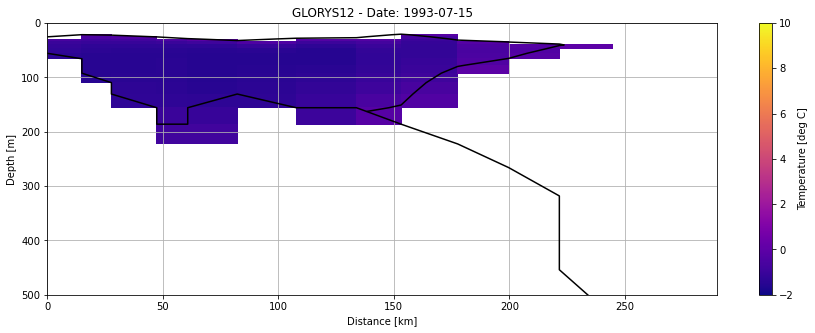

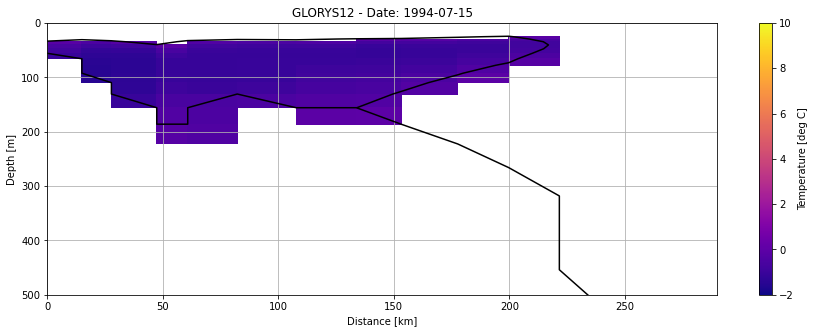

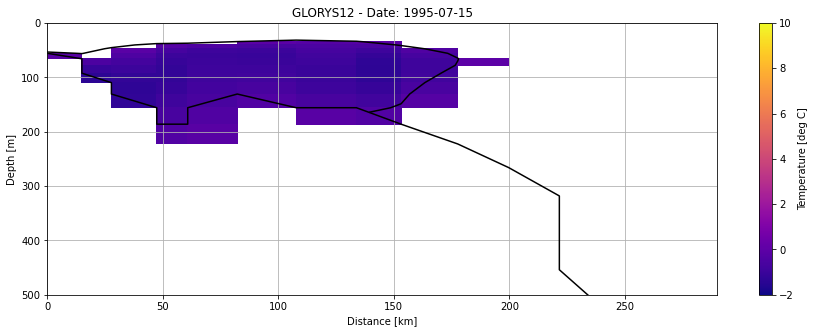

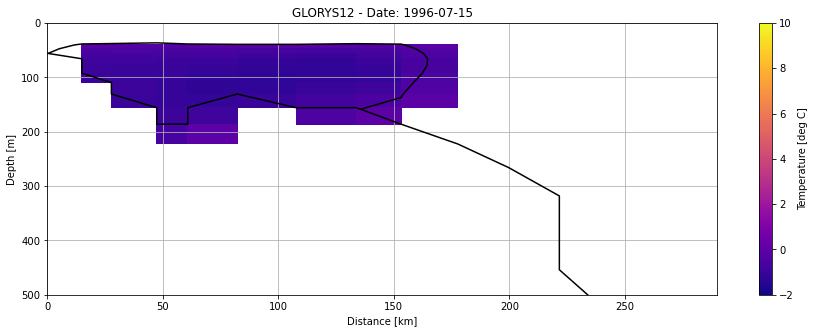

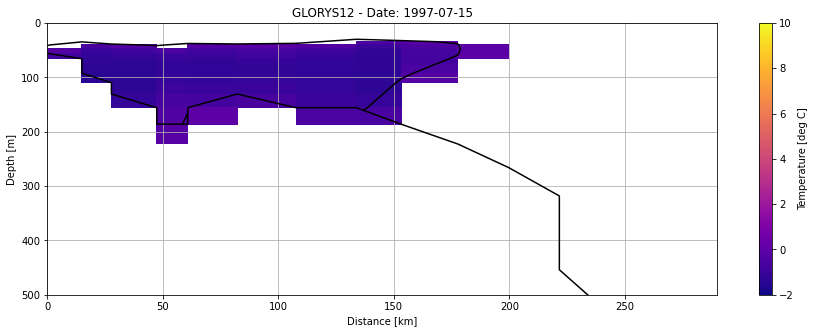

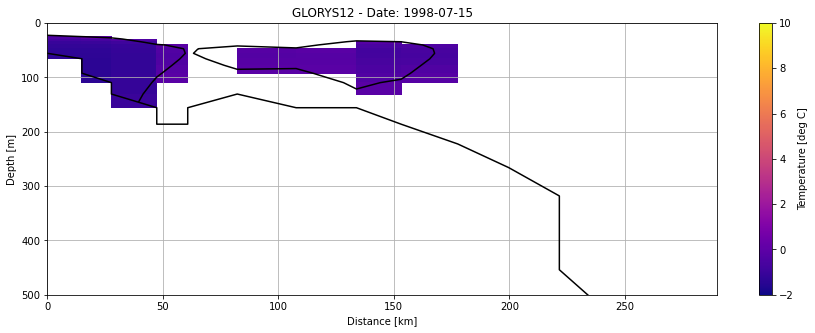

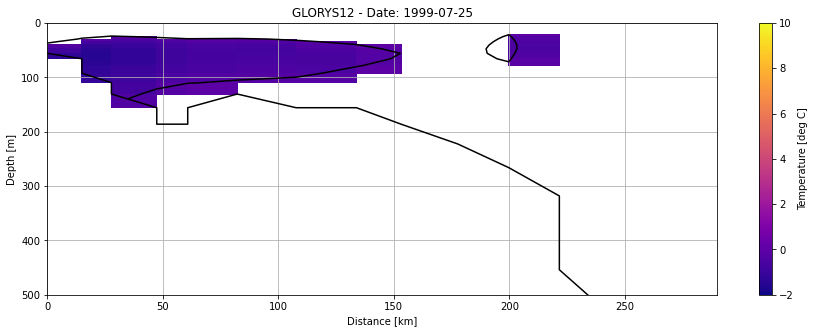

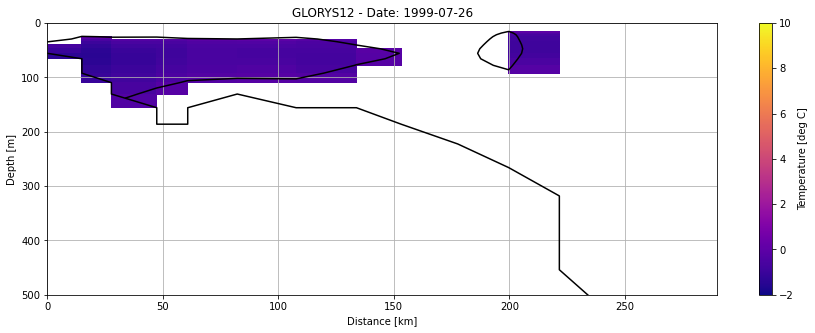

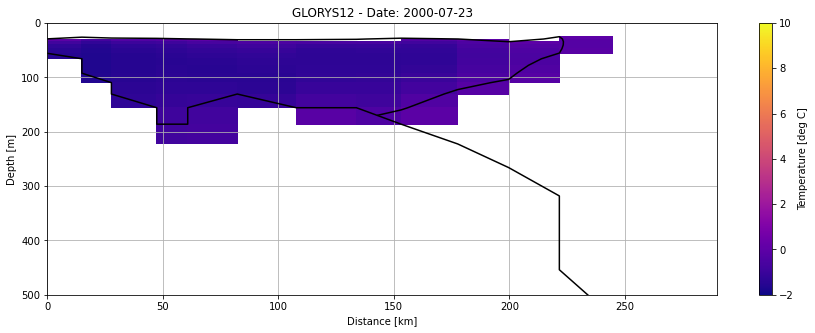

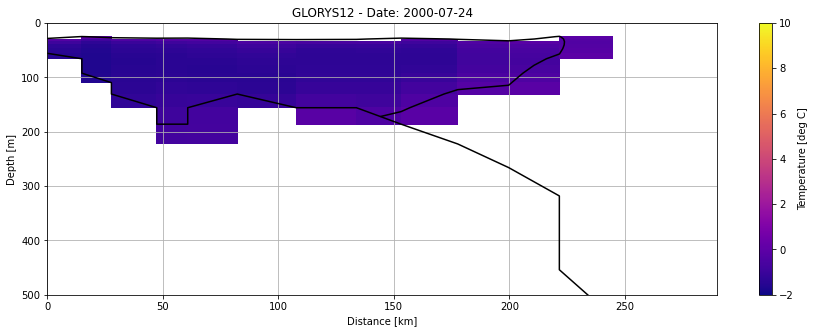

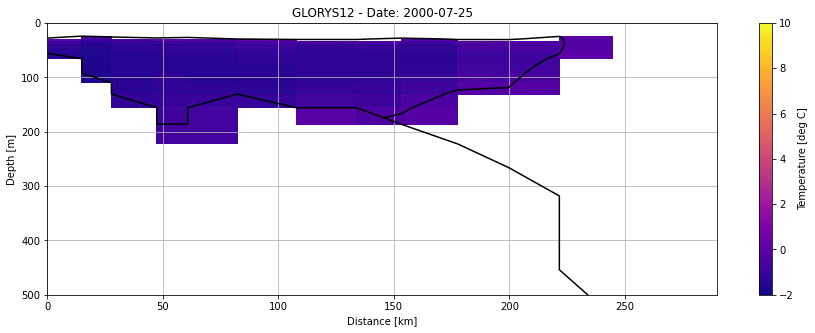

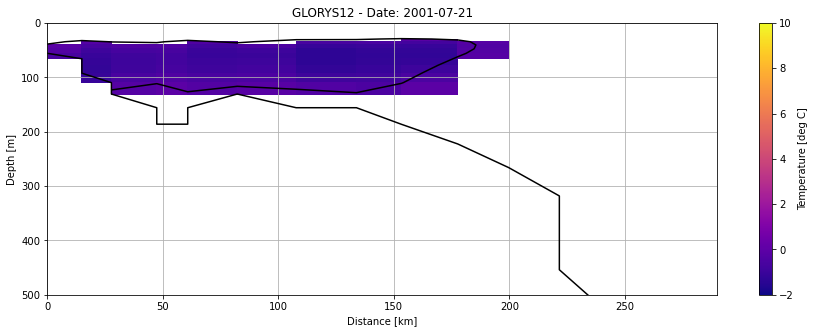

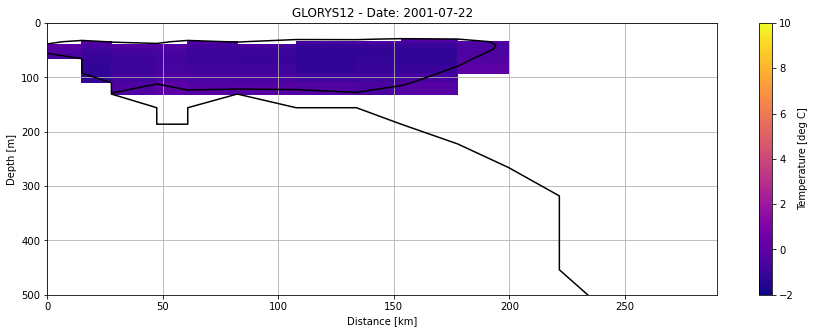

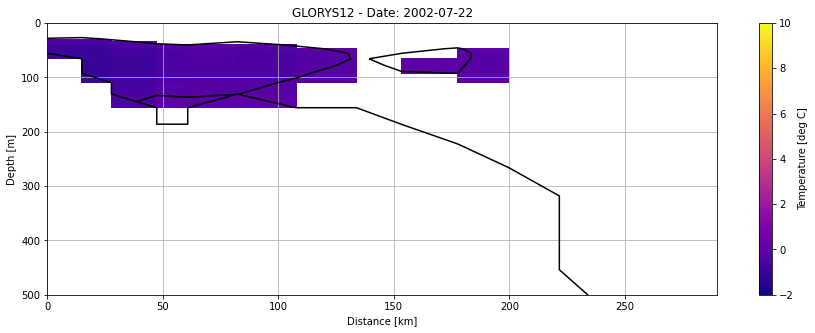

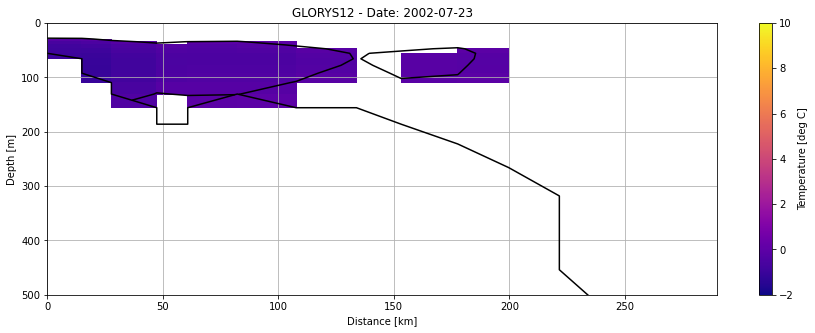

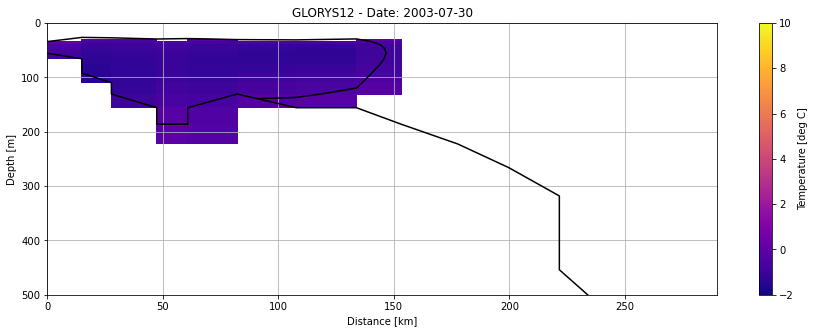

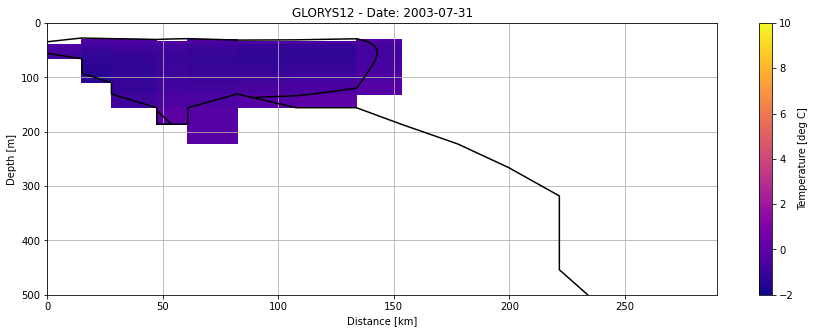

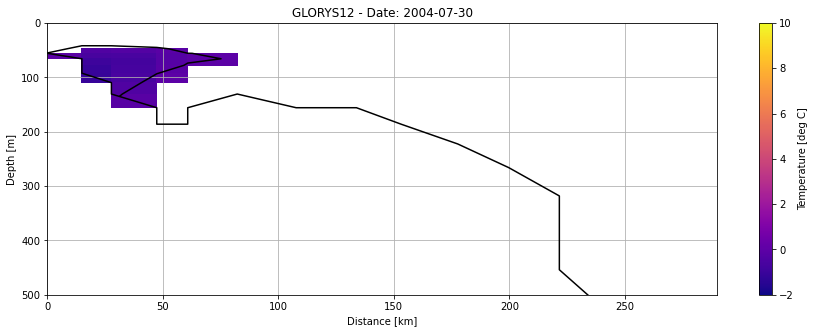

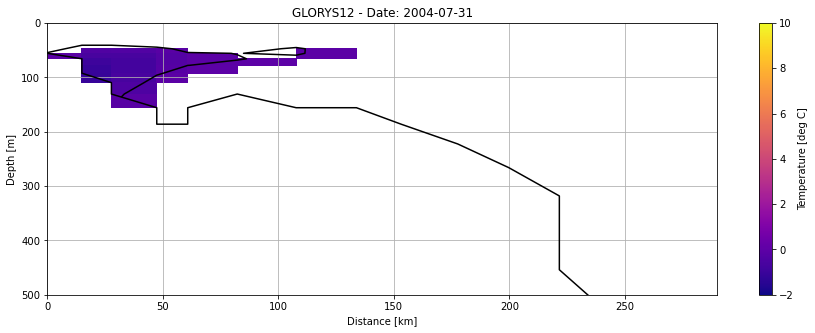

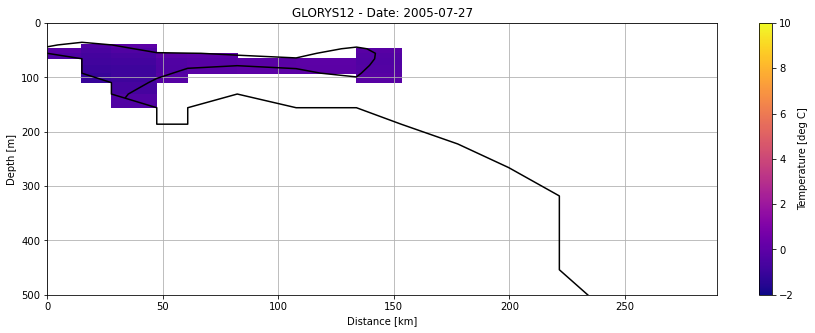

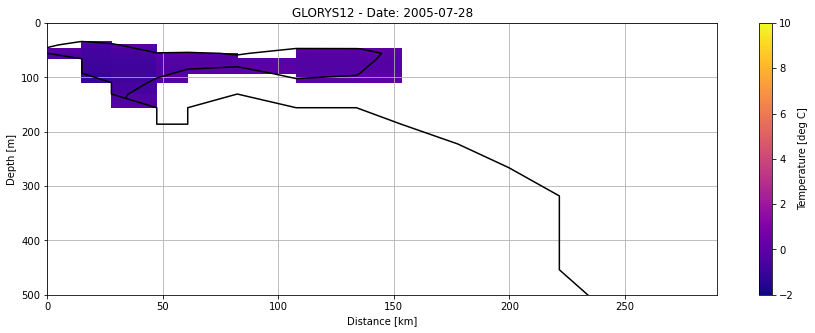

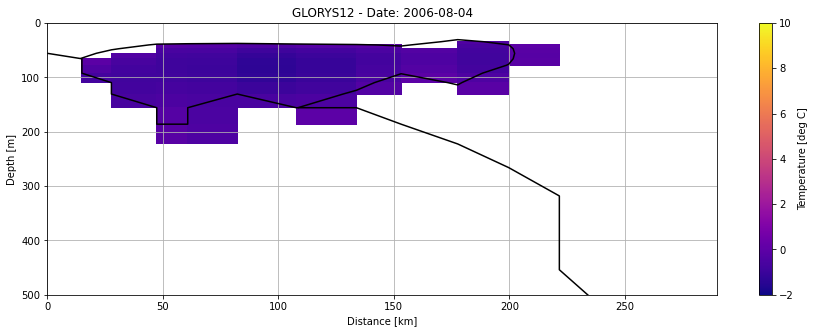

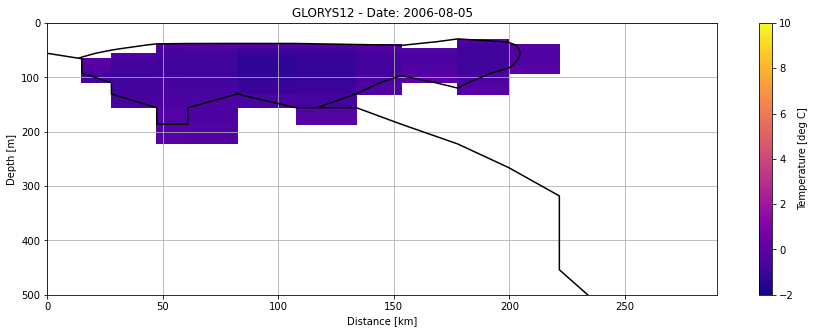

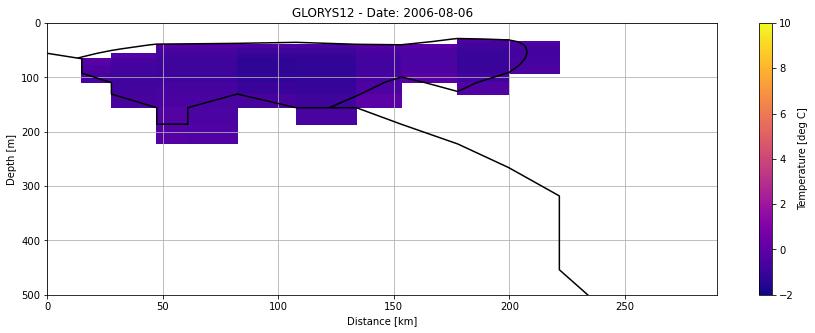

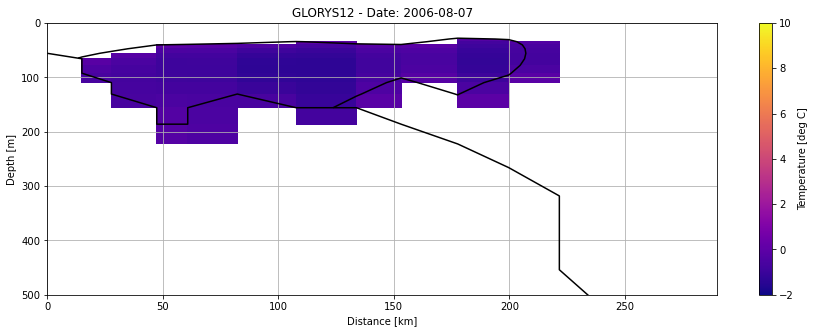

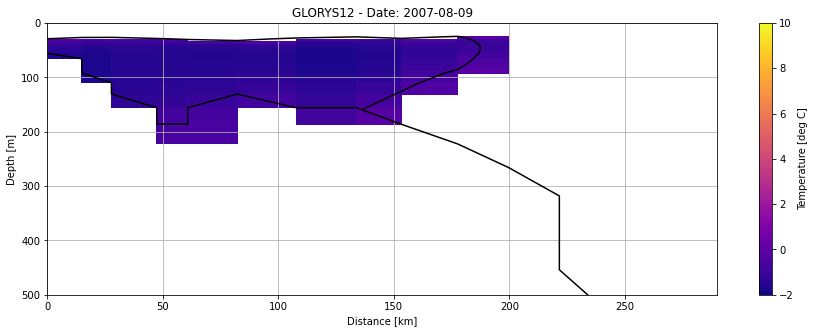

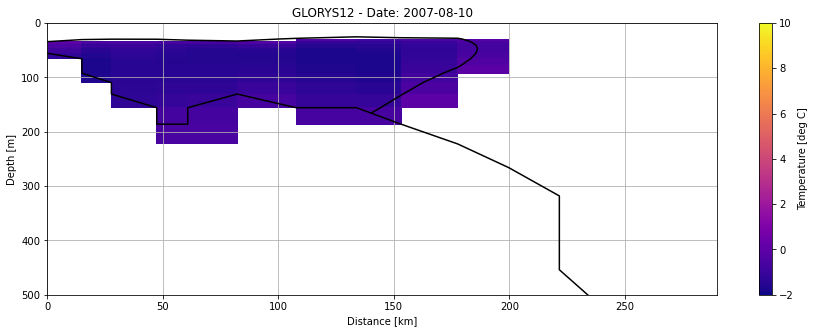

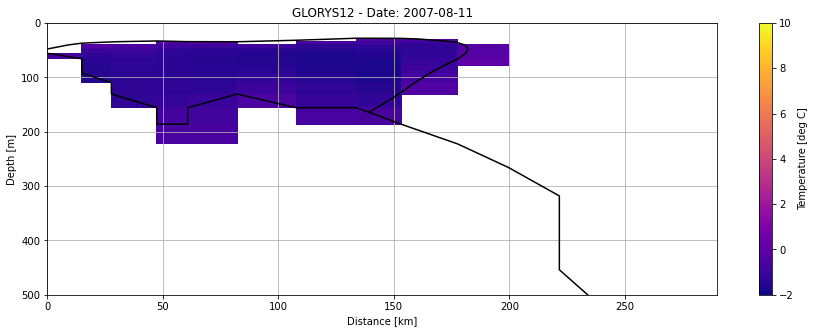

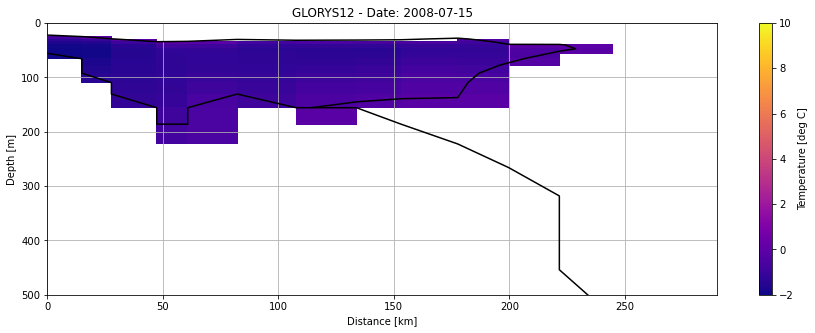

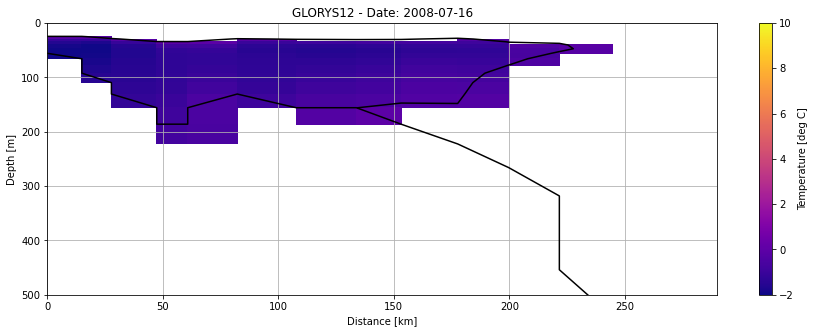

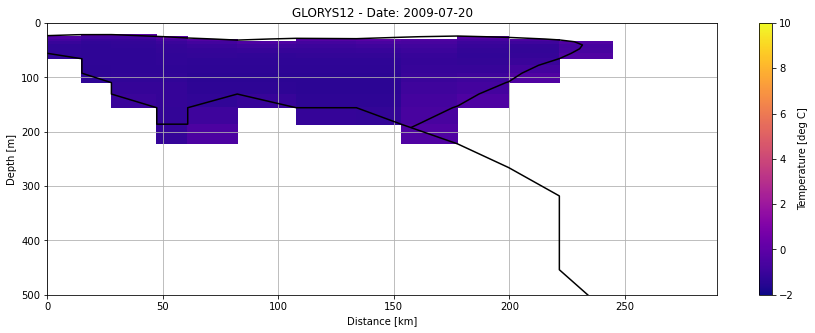

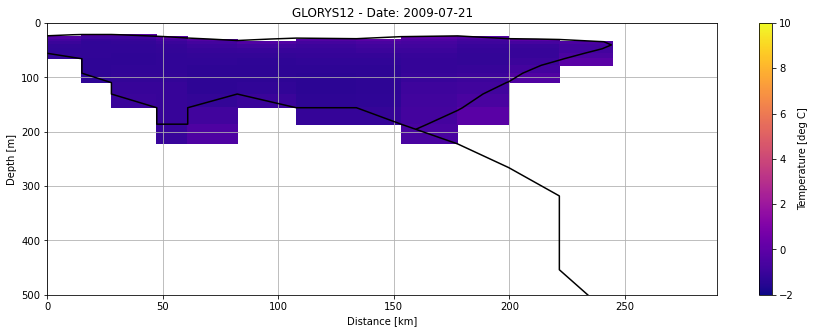

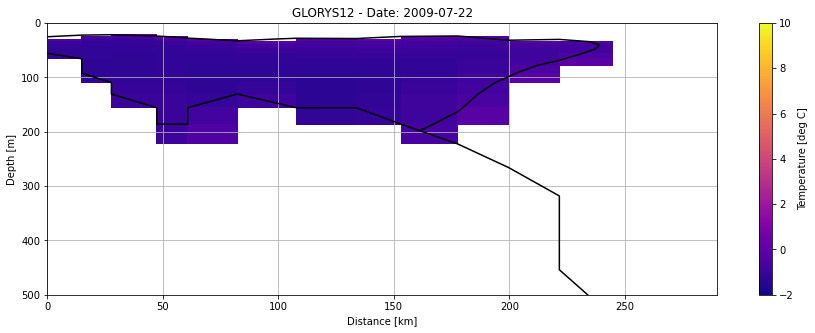

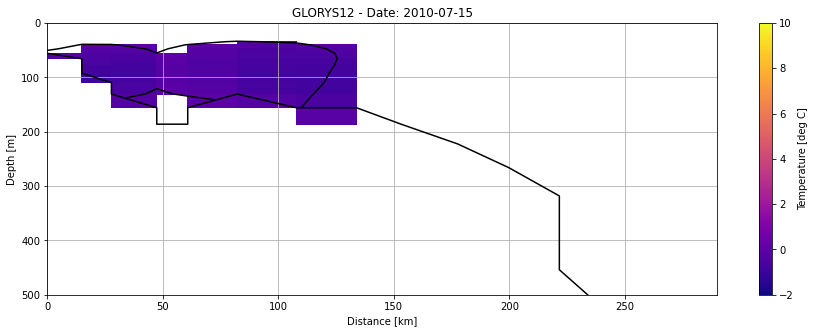

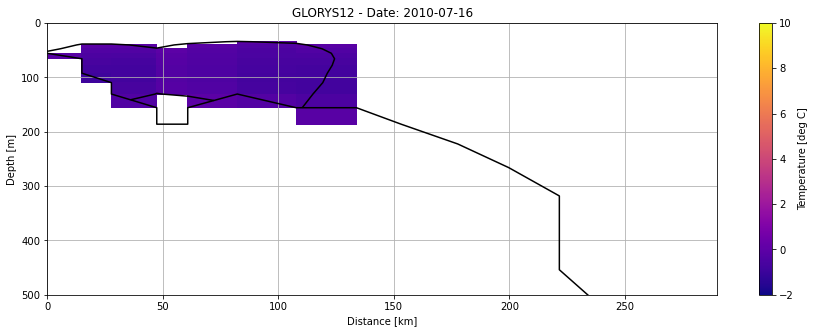

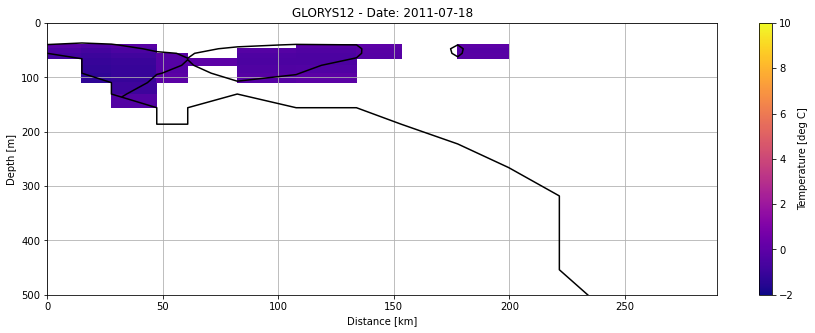

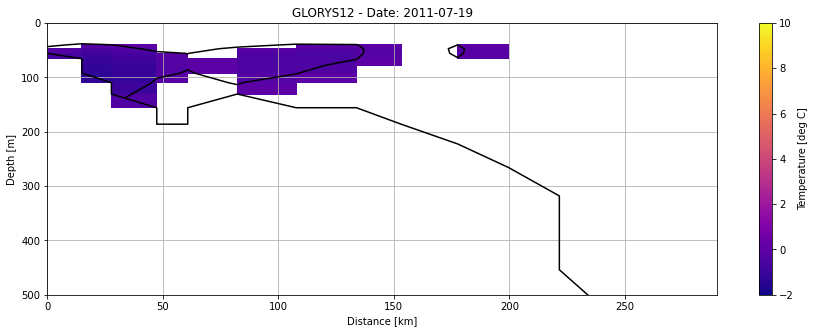

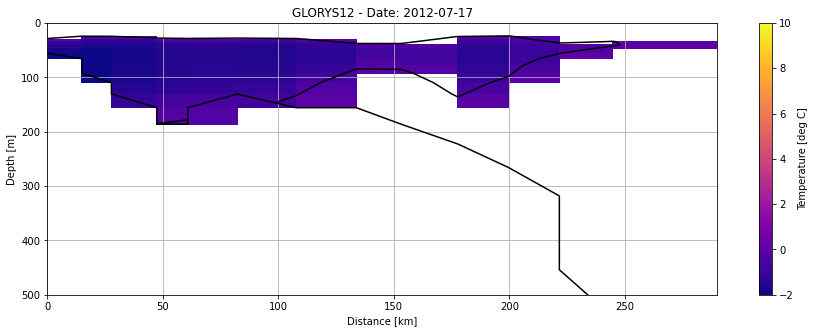

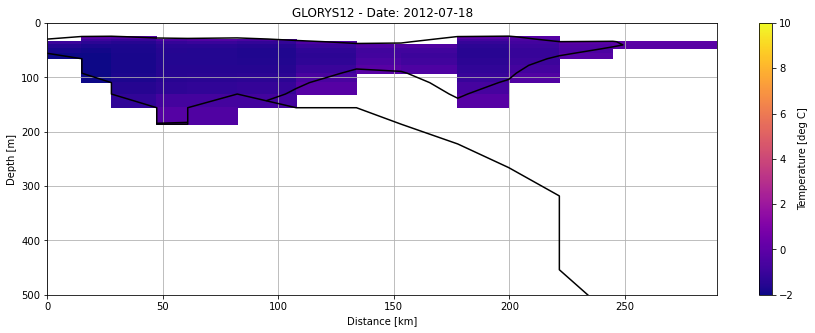

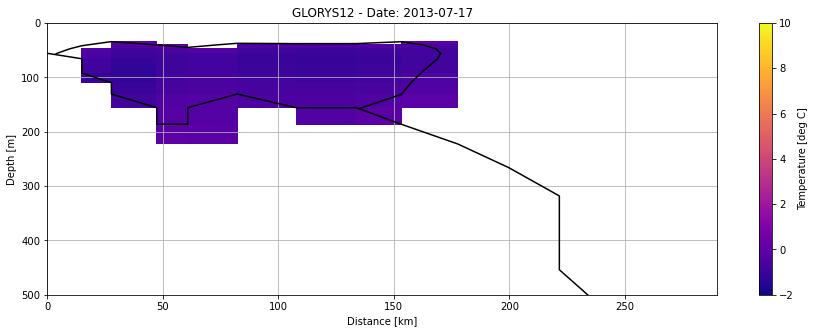

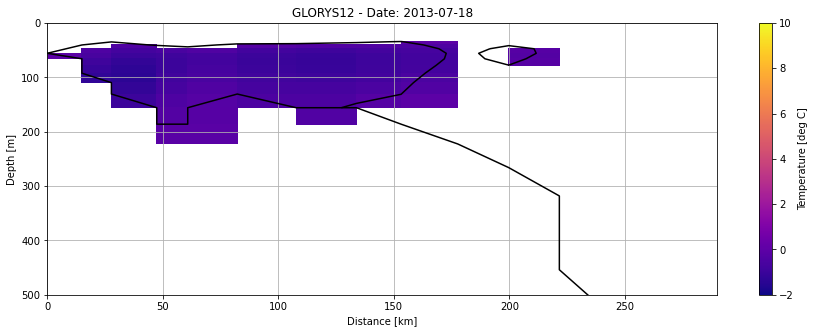

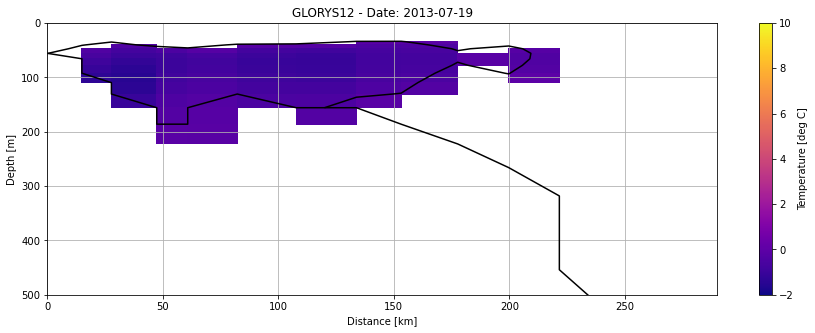

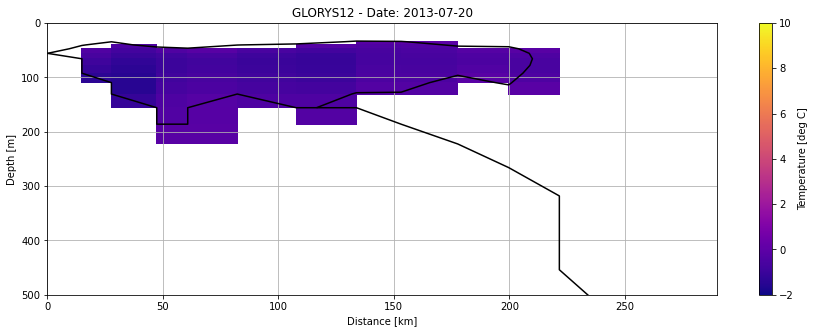

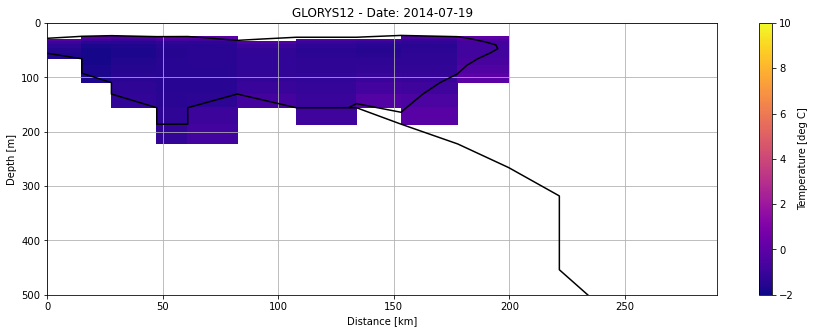

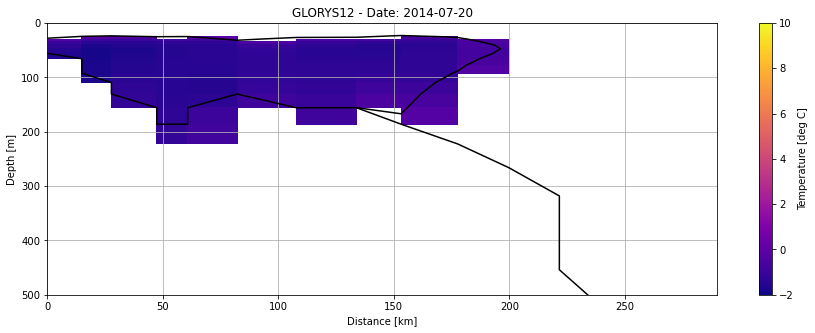

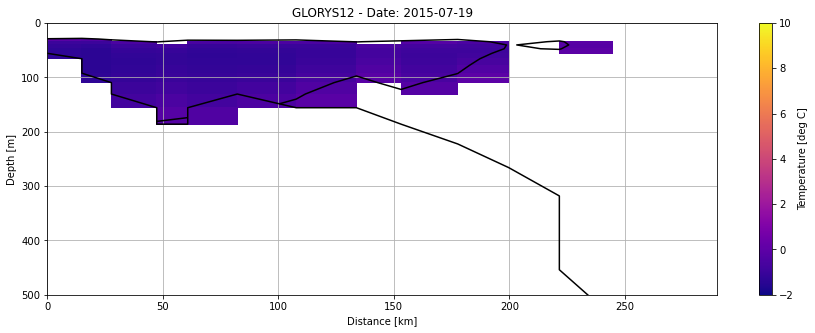

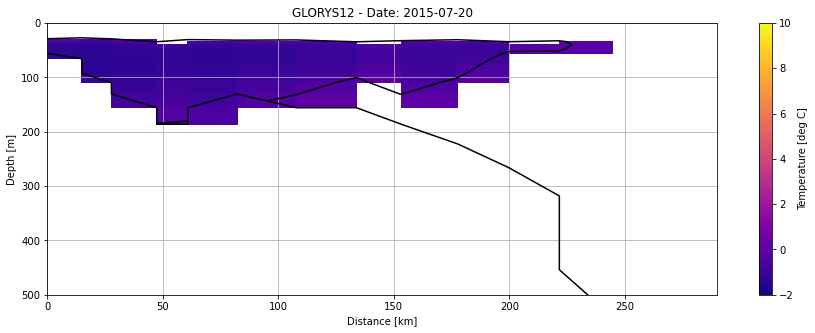

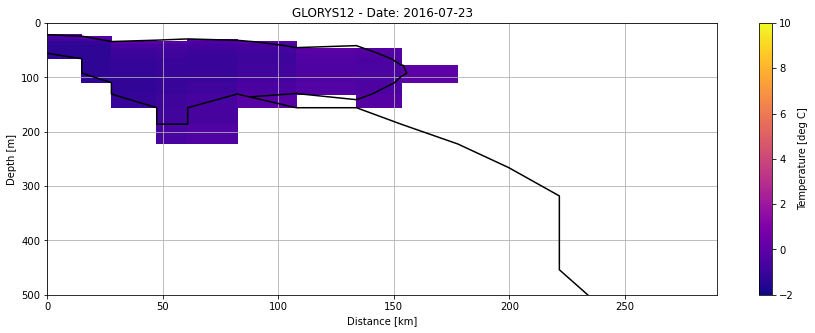

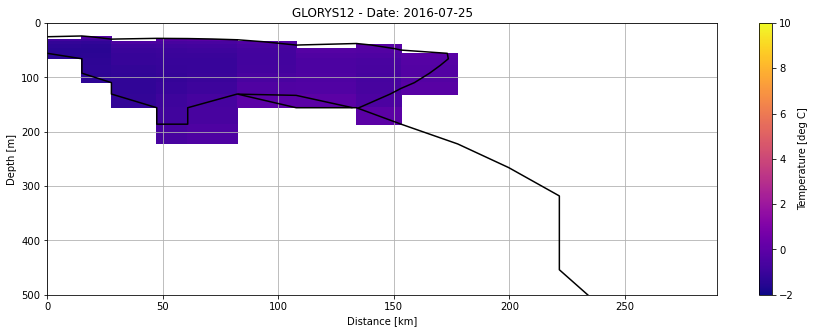

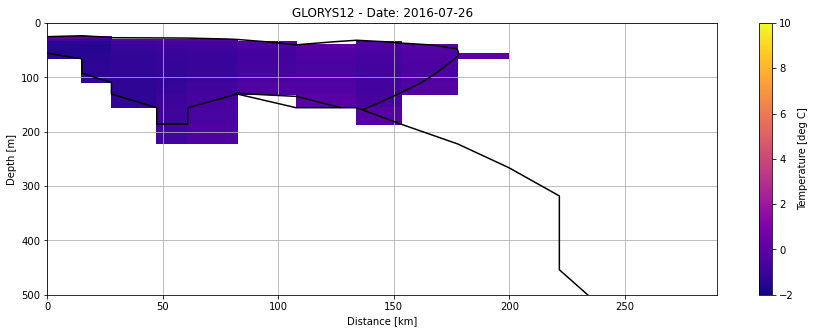

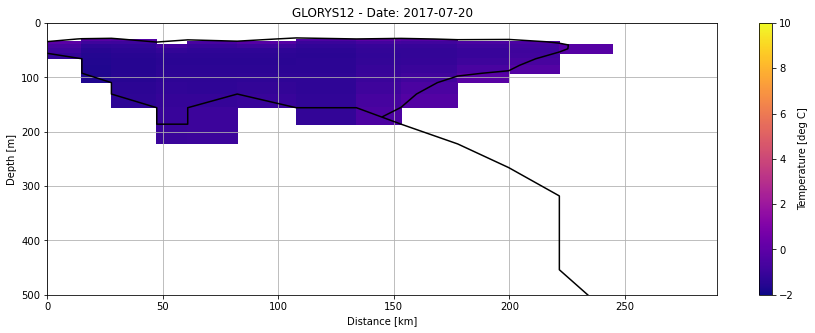

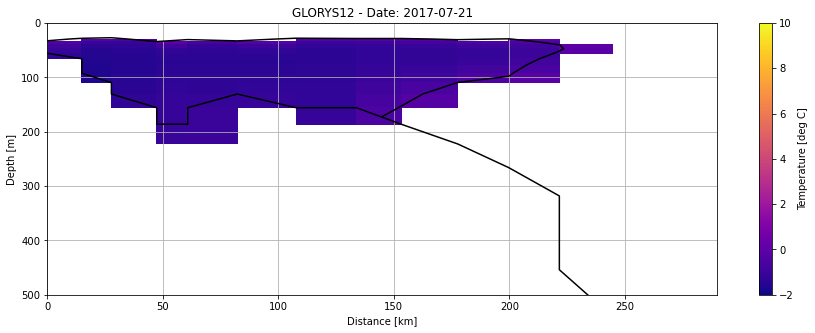

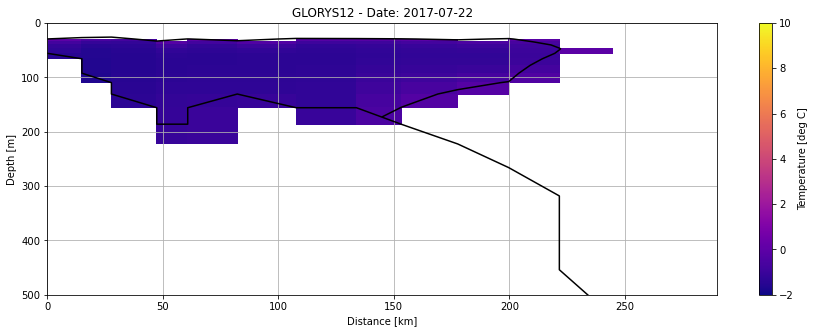

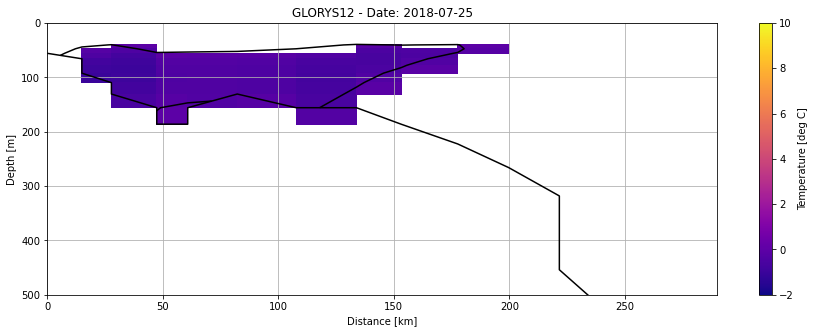

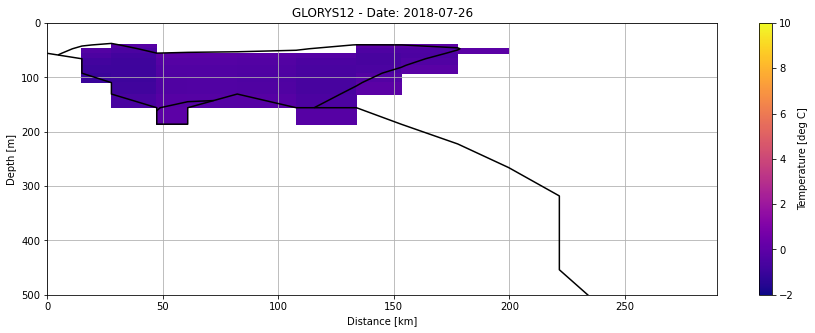

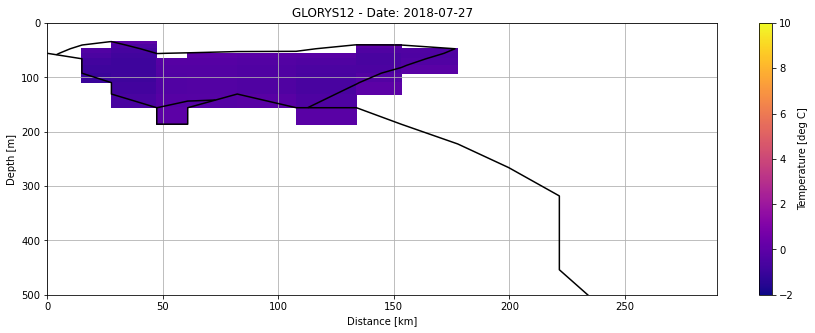

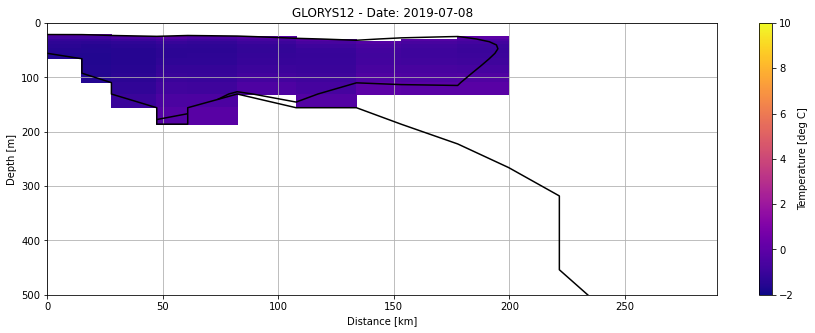

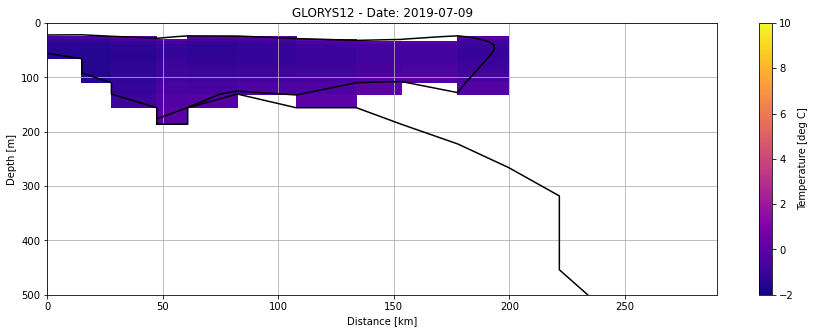

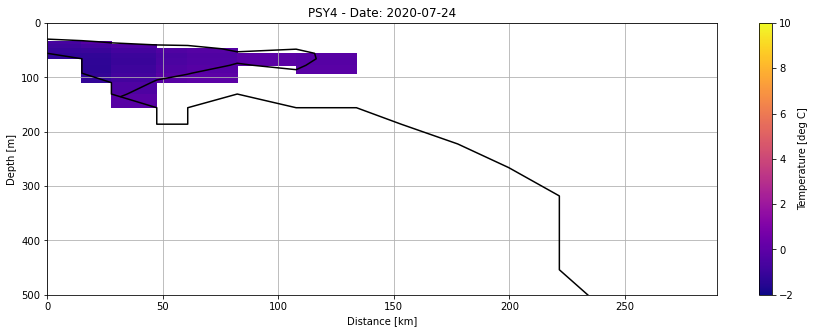

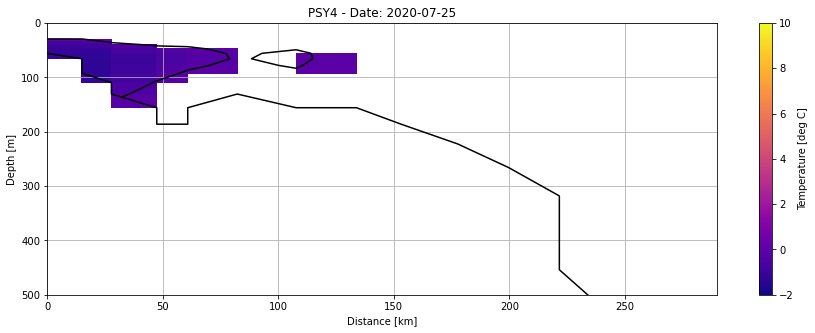

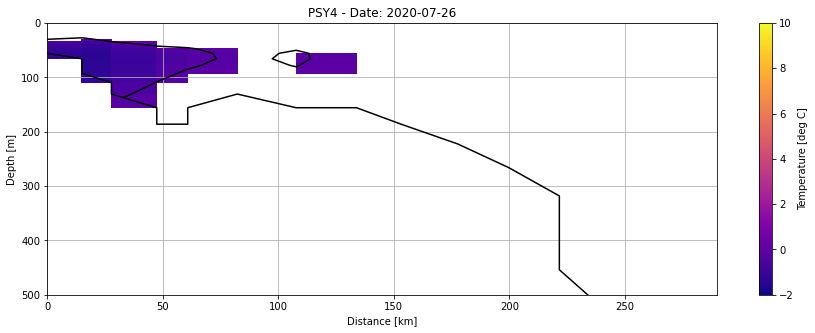

In [14]:
start=1993
end=2020
years = np.arange(start,end+1)
contour=False
index=0
df=pd.DataFrame()
for year in years:
    print('Processing year: {}'.format(year))
    # Identify AZMP dates of transect - if unknown default to July 15
    times = identify_transect_date(year,transect)
    for time in times:
        # Loop through all transect dates and isolate transect
        # Plan to look at variability with date...
        if year >= switch_year:
            # Use Psy4
            model='PSY4'
            distance, depths, var = load_psy4_data(psy4,time, transect, csv_outputs)
            fig,ax=plt.subplots(1,1, figsize=(15,5))
            plot_transect(distance,depths,var,ax, contour=contour)
        else: 
            # Use GLORYS
            model='GLORYS12'
            distance, depths, var = load_glorys_data(glorys,time, transect, csv_outputs)
            fig,ax=plt.subplots(1,1, figsize=(15,5))
            plot_transect(distance,depths,var,ax, contour=contour)
        ax.set_title('{} - Date: {}'.format(model, time.strftime('%Y-%m-%d')))
        area=calculate_area(distance, depths, var)
        fig_filename='figures/{}/{}_{}_{}.png'.format(year, model, transect, time.strftime('%Y-%m-%d'))
        if not contour:
            fig_filename='figures/{}/grid/{}_{}_{}.png'.format(year, model, transect, time.strftime('%Y-%m-%d'))
        fig.savefig(fig_filename,
                    bbox_inches='tight')
        dnew = pd.DataFrame({'Year': year, 'Model': model, 'Area (km^2)': area, 'Date':[time.strftime('%Y-%m-%d')]})
        df = pd.concat([df, dnew])

In [15]:
df = df.reset_index()
df.to_csv('{}/{}_CIL_Area_TimeSeries.csv'.format(csv_outputs, transect))

# Reorganize data and compare with observations

In [16]:
# Load obs
obsf = os.path.join(os.path.dirname(os.path.dirname(azmp)), 'CIL_area_SI.csv')
obs = pd.read_csv(obsf, names=['Year', 'Area (km^2)', 'Area2'])
obs = obs[(obs['Year']>=1993) & (obs['Year']<=2020)]
obs['Year'] = obs['Year'].astype(int)
obs['Area (km^2)'] = obs['Area (km^2)'].astype(float)


In [17]:
groups = df.groupby('Year')
dsummary=pd.DataFrame()
for year, dg in groups:
    summary=dg['Area (km^2)'].apply(['mean', 'std', 'count'])
    dnew = pd.DataFrame({'Year': [year], 'Area (km^2)': summary['mean']})
    dsummary = pd.concat([dsummary, dnew])

Text(0, 0.5, 'CIL Area (km^2)')

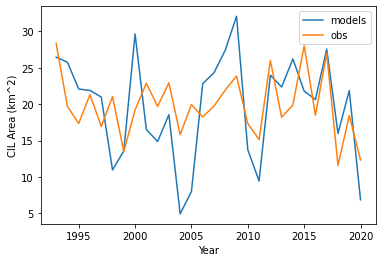

In [18]:
fig,ax=plt.subplots(1,1)
dsummary.plot(x='Year', y='Area (km^2)',label='models',ax=ax)
obs.plot(x='Year', y='Area (km^2)',label='obs',ax=ax)
ax.set_ylabel('CIL Area (km^2)')

In [19]:
dsummary['anomaly'] = (dsummary['Area (km^2)'] - dsummary['Area (km^2)'].mean())/dsummary['Area (km^2)'].std()
obs['anomaly'] = (obs['Area (km^2)'] - obs['Area (km^2)'].mean())/obs['Area (km^2)'].std()

Text(0.5, 1.0, 'Climatological period: 1993-2020')

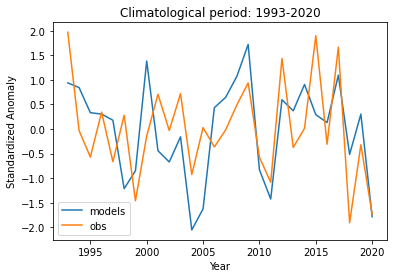

In [20]:
fig,ax=plt.subplots(1,1)
dsummary.plot(x='Year', y='anomaly',label='models',ax=ax)
obs.plot(x='Year', y='anomaly',label='obs',ax=ax)
ax.set_ylabel('Standardized Anomaly')
ax.set_title('Climatological period: 1993-2020')

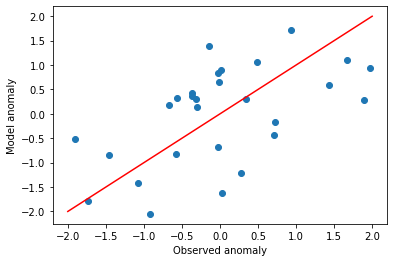

In [21]:
fig,ax=plt.subplots(1,1)
ax.plot(obs['anomaly'], dsummary['anomaly'], 'o')
ax.set_ylabel('Model anomaly')
ax.set_xlabel('Observed anomaly')
ax.plot([-2,2], [-2,2], 'r-')

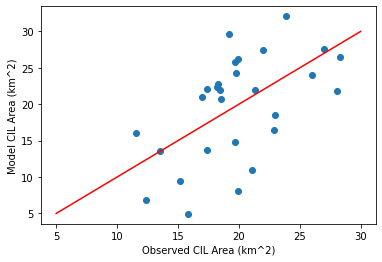

In [22]:
fig,ax=plt.subplots(1,1)
ax.plot(obs['Area (km^2)'], dsummary['Area (km^2)'], 'o')
ax.set_ylabel('Model CIL Area (km^2)')
ax.set_xlabel('Observed CIL Area (km^2)')
ax.plot([5, 30], [5, 30], 'r-')